Import librerie

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from lime import lime_text
import unicodedata
import pandas as pd
from string import punctuation
import numpy as np
import torch
from nltk.tokenize import word_tokenize
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
from tqdm import tqdm
from sklearn import preprocessing

Import dataset

In [41]:
df = pd.read_excel('../input/ciao9cci/politica.xlsx', sheet_name="Foglio1")
print(f'Found {len(df)} texts.')

print(f'{df["cap_maj_master"].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df['cap_maj_master'])]

print(f'{df["testo"].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df['testo'])]

le = preprocessing.LabelEncoder()
le.fit(df['cap_maj_master'])
df['cap_maj_master']=le.transform(df['cap_maj_master'])
classes = [int(c) for c in df['cap_maj_master'].values]
documents = [d for d in df['testo']]
print(len(documents))
print(len(classes))

Found 5674 texts.
2 document(s) with no classification removed
424 document(s) with no text removed
5248
5248


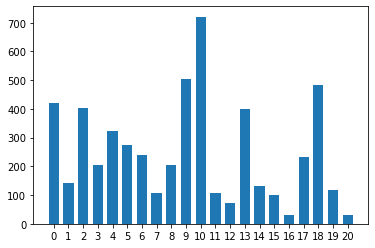

In [42]:
y = np.bincount(classes)
x = np.arange(len(y))
fig, ax = plt.subplots()
plt.bar(x, y,width=0.7)
ax.set_xticks(x)
ax.set_aspect('auto')
plt.show()


preprocessing

In [43]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    #text = re.sub(r'[^\w\s]'," ", text)
    text=re.sub('\d+',' ',str(text))
    text=re.sub('[ﾫﾻ]','',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower().strip()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

stop=set(stopwords.words('italian'))

def tokenizer_porter(text):
    word_tokens = word_tokenize(text)
    stemmer = SnowballStemmer("italian", ignore_stopwords=True)
    return [stemmer.stem(word) for word in word_tokens]
  

def tokenizer(text):
    stop=set(stopwords.words('italian'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    filtered_sentence = [w for w in filtered_sentence if len(w)>3]
    return filtered_sentence

In [44]:
def split_words_documents(documents):
    tokenized = documents = [tokenizer(strip_accents(preprocessor(document))) 
                              for document in documents]
    all_text = []
    lenght_text = []
    for tokens in tokenized:
        lenght_text.append(len(tokens))
        for t in tokens:
            all_text.append(t)
    return tokenized, lenght_text, set(all_text)

documents,lenght, vocab = split_words_documents(documents)
print(len(documents))
print(len(lenght))

5248
5248


In [45]:
print(np.max([len(x) for x in documents]))
print(np.mean([len(x) for x in documents]))

1375
200.98799542682926


In [46]:
vocaboli_more=set(line.strip() for line in open('../input/prova2/prova.txt'))
vocaboli_more=vocaboli_more.union(vocab)

In [47]:
def create_dictionaries(words):
    word_to_int_dict = {w:i+1 for i,w in enumerate(words)}
    int_to_word_dict = {i:w for w,i in word_to_int_dict.items()}
    return word_to_int_dict, int_to_word_dict
word_to_int_dict, int_to_word_dict = create_dictionaries(vocaboli_more)

In [48]:
def pad_text(tokenized_documents,seq_length):
    documents = []
    for document in tokenized_documents:
        if len(document) >= seq_length:
            documents.append(document[:seq_length])
        else:
            documents.append(['']*(seq_length-len(document))+document)
    return np.array(documents)
padded_sentences = pad_text(documents, seq_length = 700)  

In [49]:
int_to_word_dict[0]=''
word_to_int_dict['']=0

In [50]:
encoded_sentences = np.array([[word_to_int_dict[word] for word in content] for content in padded_sentences])

In [51]:
print(encoded_sentences.shape)

(5248, 700)


In [52]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.double)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [53]:
# Load pretrained vectors
print("Tokenizing...\n")
embeddings = load_pretrained_vectors(word_to_int_dict, "../input/fasttext-aligned-word-vectors/wiki.it.align.vec")
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


871053it [00:39, 21857.22it/s]


There are 144467 / 294543 pretrained vectors found.


In [54]:
class ClassificationCNN(nn.Module):
    
    def __init__(self, 
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 n_vocab=None, 
                 n_embed=300,
                 n_filters=100, 
                 n_output=1, 
                 filter_sizes=[2,3,4], 
                 dropout = 0.8,
                 pad_idx=0.0):
        super().__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.n_vocab, self.n_embed = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        
        
         
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, self.n_embed)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, n_output)
        
        self.dropout = nn.Dropout(dropout)
        

        
        
    def forward(self, text):
        
        emb = self.embedding(text).unsqueeze(1)
        
        conved = [F.relu(c(emb)).squeeze(3) for c in self.convs]
                
        pooled = [F.max_pool1d(c, c.shape[2]).squeeze(2) for c in conved]
        
        concat = self.dropout(torch.cat(pooled, dim = 1))
            
        return self.fc(concat)

In [55]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

In [56]:
def evaluate(model, data_loader, criterion):
    model.eval()
    val_accuracy = []
    val_loss = []
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(data_loader):
            logits= model(x_batch)
            loss = criterion(logits, y_batch)
            val_loss.append(loss.item())
            
            _, preds = torch.max(logits, 1)
            accuracy = (preds == y_batch).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

In [57]:
import time
import random
import torch.nn.functional as F



In [58]:
def create_data_loader(train_c, valid_c, train_l,valid_l,batch_size):
    x_train = torch.tensor(train_c, dtype=torch.long,device=DEVICE)
    y_train = torch.tensor(train_l, dtype=torch.long, device=DEVICE)
    x_cv = torch.tensor(valid_c, dtype=torch.long, device=DEVICE)
    y_cv = torch.tensor(valid_l, dtype=torch.long, device=DEVICE)
    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train, y_train)
    valid = torch.utils.data.TensorDataset(x_cv, y_cv)
    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader
    

In [59]:
def plot_graph(epochs, train_loss, valid_loss):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) ) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) ), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    plt.show()

In [60]:
def train(model, optimizer,criterion, train_loader, val_loader=None, epochs=10):
    best_accuracy = 0
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)
    countdown=epochs
    count=0
    train_loss = []
    valid_loss = []
    while countdown>0:
        start_time = time.time()
        t0_epoch = time.time()
        total_loss = 0
        model.train()
        step=1
        for i, (x_batch, y_batch) in enumerate(train_loader):
            y_pred= model(x_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        avg_train_loss = total_loss / len(train_loader)
        val_loss, val_accuracy = evaluate(model, val_loader,criterion)
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'tut5-model.pt')
            countdown=epochs
            
        else:
            countdown=countdown-1
        time_elapsed = time.time() - t0_epoch
        count+=1
        print(f"{count :^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        train_loss.append(avg_train_loss)
        valid_loss.append(val_loss)
        if(val_loss>avg_train_loss):
            break
        
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")
    plot_graph(count, train_loss, valid_loss)
    return best_accuracy
    

In [61]:
batch_size = 50
n_output = len(np.unique(classes))
number_of_filters = 100
filter_sizes = [2,3,4]
dropout_pc = 0.8
n_epochs = 10
nfold=10

In [62]:
def pytorch_predict(model, test_loader):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    labels=[]
    with torch.no_grad():
        for (text, label) in test_loader:             
            outputs = model(text)
            _, preds = torch.max(outputs, 1)
            for pred in preds:
                labels.append(pred.item())
    
    return labels

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  140.894335  | 129.598161 |   20.36   |   10.76  
   2    |  121.899510  | 105.111837 |   44.91   |   10.70  
   3    |  96.449688   | 89.366644  |   50.55   |   10.80  
   4    |  81.435971   | 80.515399  |   55.09   |   10.73  
   5    |  68.293839   | 74.241546  |   57.64   |   10.72  


Training complete! Best accuracy: 57.64%.
[140.89433503295538, 121.89950959328482, 96.44968811929843, 81.43597094258031, 68.2938392745839]
[129.59816131724168, 105.11183727076944, 89.36664378516717, 80.5153985316209, 74.24154573927947]


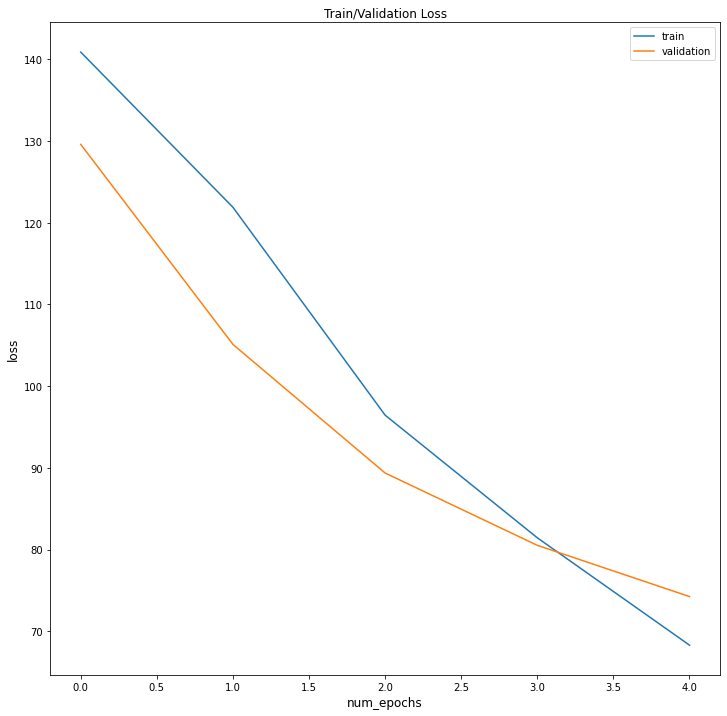

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------- Fold:  1 ---------------------

              precision    recall  f1-score   support

           0       0.42      0.60      0.50        42
           1       1.00      0.07      0.12        15
           2       0.78      0.72      0.75        40
           3       0.78      0.67      0.72        21
           4       0.56      0.62      0.59        32
           5       0.83      0.89      0.86        27
           6       0.60      0.50      0.55        24
           7       0.50      0.27      0.35        11
           8       0.82      0.45      0.58        20
           9       0.68      0.82      0.75        50
          10       0.59      0.79      0.68        73
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.32      0.40      0.36        40
          14       0.71      0.77      0.74        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

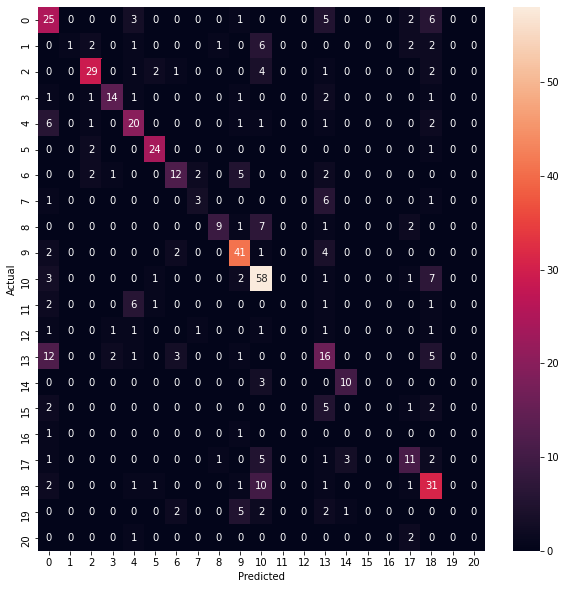


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  140.845587  | 129.505490 |   15.09   |   10.68  
   2    |  122.662009  | 103.558894 |   45.09   |   10.67  
   3    |  96.757739   | 87.356016  |   50.36   |   10.95  
   4    |  81.406676   | 80.472951  |   54.91   |   10.70  
   5    |  68.227782   | 75.565113  |   55.64   |   10.70  


Training complete! Best accuracy: 55.64%.
[140.84558708903037, 122.66200897132342, 96.75773921495893, 81.40667648201114, 68.22778158612938]
[129.50548968568347, 103.55889400514324, 87.35601555393923, 80.47295113148998, 75.5651128338636]


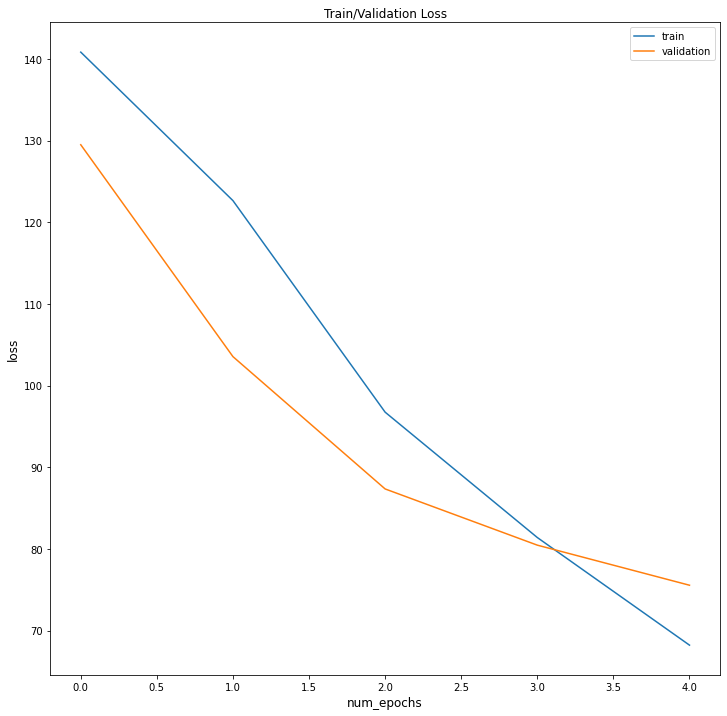

--------------- Fold:  2 ---------------------

              precision    recall  f1-score   support

           0       0.40      0.55      0.46        42
           1       0.00      0.00      0.00        15
           2       0.71      0.88      0.79        40
           3       0.64      0.67      0.65        21
           4       0.48      0.50      0.49        32
           5       0.85      0.81      0.83        27
           6       0.60      0.75      0.67        24
           7       1.00      0.64      0.78        11
           8       0.29      0.30      0.29        20
           9       0.75      0.88      0.81        50
          10       0.53      0.81      0.64        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.33      0.38      0.35        40
          14       0.56      0.38      0.45        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

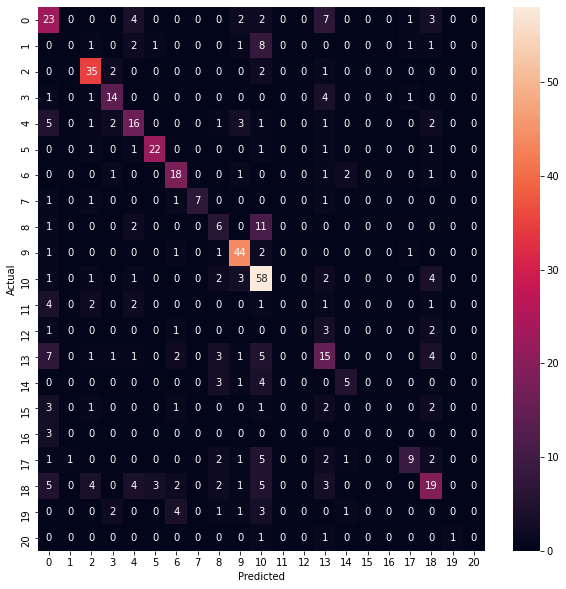


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  140.048765  | 127.107882 |   20.00   |   10.71  


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
X=encoded_sentences
y=np.array(classes)
kfold = StratifiedKFold(n_splits=nfold).split(X, y)

accuracys = []
scores= []
target_names=np.unique(classes)
#target_names=le.inverse_transform(target_names)

for k, (train_ids, test_ids) in enumerate(kfold):
    
    train_loader, val_loader=create_data_loader(X[train_ids],X[test_ids],y[train_ids],y[test_ids],batch_size)
    

    model = ClassificationCNN(
                        pretrained_embedding=embeddings, 
                        n_output=n_output,
                        filter_sizes=filter_sizes,
                        dropout=dropout_pc,
                        n_filters=number_of_filters)
    model=model.double()
    
    loss_fn = nn.CrossEntropyLoss(reduction='sum').to(DEVICE)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    model.to(DEVICE)
    accuracy=train(model,optimizer,loss_fn,train_loader,val_loader,n_epochs)
    accuracys.append(accuracy)
    
    model.load_state_dict(torch.load('tut5-model.pt'))
    
    y_pred=pytorch_predict(model,val_loader)
    
    y_true=y[test_ids]
    
    score=precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, labels=target_names, average="weighted")
    scores.append(score[0:3])
    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=target_names , yticklabels=target_names )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

arr = np.array(scores)
print("Overall results of the cross-validation procedure")
print()

print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(accuracys), np.std(accuracys)))
print('\nCV precision: %.3f +/- %.3f' % (np.mean(arr[:,0]), np.std(arr[:,0])))
print('\nCV recall: %.3f +/- %.3f' % (np.mean(arr[:,1]), np.std(arr[:,1])))
print('\nCV f1: %.3f +/- %.3f' % (np.mean(arr[:,2]), np.std(arr[:,2])))